In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import matplotlib

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from tensorflow_probability.substrates import jax as tfp

In [3]:
from collections import namedtuple

In [4]:
from itertools import product

In [5]:
Scene = namedtuple('Scene', ['obj_idx', 'obj_contact_params', 'obj_face'])

In [6]:
IDENTITY_POSE = j.t3d.transform_from_pos(jnp.array([0.0, 0.0, 0.]))

In [7]:
# intrinsics = j.Intrinsics(
#     height=150,
#     width=150,
#     fx=200.0, fy=200.0,
#     cx=75.0, cy=75.0,
#     near=0.001, far=1.0
# )
intrinsics = j.Intrinsics(
    200,
    200,
    400.0,
    400.0,
    100.0,
    100.0,
    0.02,
    10.0
)

renderer = j.Renderer(intrinsics)

Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [8]:
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")
MODEL_NAMES = j.ycb_loader.MODEL_NAMES
for IDX in range(len(MODEL_NAMES)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(j.mesh.center_mesh(mesh), scaling_factor=1.0/1000.0)

In [9]:
pos = jnp.array([[1.0, 1.0, 1.0]])
target = jnp.array([0.0, 0.0, 0.0])
up = jnp.array([0.0, 0.0, 1.0])

cam_pose = j.t3d.transform_from_pos_target_up(pos, target, up)

In [10]:
TABLE_WID = 1.0
TABLE_LEN = 1.0
TABLE_POS = j.t3d.identity_pose()
table_mesh = j.mesh.make_cuboid_mesh(jnp.array([TABLE_WID, TABLE_LEN, 0.005]))
table_mesh = j.mesh.center_mesh(table_mesh)
renderer.add_mesh(table_mesh, scaling_factor=1.0)
TABLE_IDX = len(renderer.mesh_names) - 1

In [11]:
extent = lambda mesh: jnp.max(mesh.vertices[:, 0]) - jnp.min(mesh.vertices[:, 0])

In [12]:
prngkey = jax.random.PRNGKey(4)

In [13]:
def sample_scene(prngkey):
    obj_idx = jax.random.randint(prngkey, (1,), 0, len(MODEL_NAMES))[0]
    dx = TABLE_WID * (jax.random.uniform(prngkey) -0.5) / 2
    dy = TABLE_LEN * (jax.random.uniform(prngkey) -0.5) / 2
    theta = 2*jnp.pi * jax.random.uniform(prngkey)
    obj_face = jax.random.randint(prngkey, (1,), 0, 6)[0]
    obj_contact_params = jnp.array([dx, dy, theta])
    return Scene(obj_idx, obj_contact_params, obj_face)

In [14]:
def scene_logpdf(scene):
    return -jnp.log(len(MODEL_NAMES) * TABLE_WID/2 * TABLE_LEN/2 * 2*jnp.pi * 6)

In [15]:
def render_scene(scene, renderer, cam_pose):
    dims = renderer.model_box_dims[[TABLE_IDX, scene.obj_idx], :]
    absolute_poses = jnp.array([TABLE_POS, IDENTITY_POSE])
    edges = jnp.array([[-1,0], [0,1]])
    contact_params = jnp.array([[0.0, 0.0, 0.0], scene.obj_contact_params])
    face_parents = jnp.array([1, 2])
    face_childs = jnp.array([0, scene.obj_face])
    poses = j.scene_graph.absolute_poses_from_scene_graph_jit(
        absolute_poses, dims, edges, contact_params, face_parents, face_childs)
    return renderer.render_multiobject(jnp.linalg.inv(cam_pose) @ poses, [TABLE_IDX, scene.obj_idx])

In [16]:
def generate_obs(prngkey, gt_img, r):
    scene = sample_scene(prngkey)
    gt_depth = gt_img[..., 2]
    noise = jax.random.normal(prngkey, gt_depth.shape) * r
    #gt_depth = gt_depth.at[gt_depth < intrinsics.near].set(intrinsics.far)
    return j.t3d.unproject_depth_jit(gt_depth + noise, intrinsics)

In [17]:
def likelihood_logpdf(noisy_img, gt_img, r):
    gt_depth = gt_img[...,2]
    noisy_depth = noisy_img[...,2]
    #mask = gt_depth > intrinsics.near
    logpdfs = tfp.distributions.Normal(loc=gt_depth, scale=r*jnp.ones_like(gt_depth)).prob(noisy_depth)
    return jnp.sum(logpdfs)#[mask])

In [18]:
def model_sampler(prngkey, r, renderer, cam_pose):
    scene = sample_scene(prngkey)
    gt_img = render_scene(scene, renderer, cam_pose)
    obs = generate_obs(prngkey, gt_img, r)
    return scene, obs

In [19]:
def model_logpdf(scene, obs, r, renderer, cam_pose):
    gt_img = render_scene(scene, renderer, cam_pose)
    return scene_logpdf(scene) + likelihood_logpdf(obs, gt_img, r)

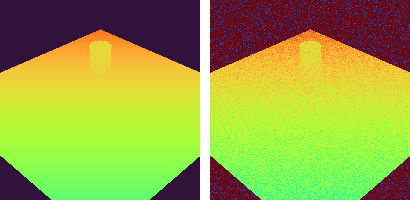

In [20]:
r = 0.1
scene, obs = model_sampler(prngkey, r, renderer, cam_pose)
gt_img = render_scene(scene, renderer, cam_pose)
j.hstack_images([j.get_depth_image(gt_img[:,:,2], max=3.0), j.get_depth_image(obs[:,:,2], max=3.0)])

In [21]:
model_logpdf(scene, obs, r, renderer, cam_pose)

Array(91423.98, dtype=float32)

In [22]:
class Grid: # XXX only continuous for now
    def __init__(self, x_range, y_range, t_range, mx, my, mt):
        self.mx, self.my, self.mt = mx, my, mt
        self.x_grid, self.dx = Grid._make_grid(x_range, mx)
        self.y_grid, self.dy = Grid._make_grid(y_range, my)
        self.t_grid, self.dt = Grid._make_grid(t_range, mt)
    
    def _make_grid(var_range, m):
        var_min, var_max = var_range
        return jnp.linspace(0, var_max - var_min, m + 1) + var_min, (var_max - var_min)/2
            
    def sample_cells_parallel(self, prngkey):
        mx, my, mt = self.mx, self.my, self.mt
        u0x = jax.random.uniform(prngkey, (mx*my*mt,))
        u0y = jax.random.uniform(prngkey, (mx*my*mt,))
        u0t = jax.random.uniform(prngkey, (mx*my*mt,))
        ux = u0x * self.dx + jnp.repeat(self.x_grid[:-1], my*mt)
        uy = u0y * self.dy + jnp.tile(jnp.repeat(self.y_grid[:-1], mt), mx)
        ut = u0t * self.dt + jnp.tile(self.t_grid[:-1], mx*my)
        return ux, uy, ut
    
    def sample_from_cell(self, prngkey, ix, iy, it):
        u = jax.random.uniform(prngkey, (3,))
        x = self.x_grid[ix] + u[0] * (self.x_grid[ix+1] - self.x_grid[ix])
        y = self.y_grid[iy] + u[1] * (self.y_grid[iy+1] - self.y_grid[iy])
        t = self.t_grid[it] + u[2] * (self.t_grid[it+1] - self.t_grid[it])
        return x, y, t

In [23]:
def get_poses(obj_idx, obj_face, dx, dy, dt, renderer):
    dims = renderer.model_box_dims[[TABLE_IDX, obj_idx], :]
    absolute_poses = jnp.array([TABLE_POS, IDENTITY_POSE])
    edges = jnp.array([[-1,0], [0,1]])
    contact_params = jnp.array([[0.0, 0.0, 0.0], [dx, dy, dt]])
    face_parents = jnp.array([1, 2])
    face_childs = jnp.array([0, obj_face])
    poses = j.scene_graph.absolute_poses_from_scene_graph_jit(
        absolute_poses, dims, edges, contact_params, face_parents, face_childs)
    return poses

In [24]:
get_poses_parallel = jax.vmap(get_poses, in_axes=(None, None, 0, 0, 0, None))

In [25]:
likelihood_logpdfs_parallel = jax.vmap(likelihood_logpdf, in_axes=(None, 0, None))

In [26]:
def render_hypotheses_parallel(poses, obj_idx, cam_pose, renderer):
    table_poses = jnp.linalg.inv(cam_pose) @ poses[:, 0, :, :]
    obj_poses = jnp.linalg.inv(cam_pose) @ poses[:, 1, :, :]
    parallel_renderer_poses = jnp.vstack((table_poses[None,...], obj_poses[None,...]))
    return renderer.render_multiobject_parallel(parallel_renderer_poses, [TABLE_IDX, obj_idx])

In [27]:
def sample_from_scores(scores, mobj_idxs, mfaces, mx, my, mtheta):
    scores_flat = scores.reshape(-1)
    scores_normalizer = jax.scipy.special.logsumexp(scores_flat)
    p = jnp.exp(scores_flat - scores_normalizer)
    i = jax.random.choice(prngkey, len(scores_flat), p=p)
    obj_idx, face, ix, iy, it = np.unravel_index(i, (mobj_idxs, mfaces, mx, my, mtheta))
    return obj_idx, face, ix, iy, it

In [28]:
def score_grid(obs, x_range, y_range, t_range, obj_idxs, faces, mx, my, mtheta):
    grid = Grid(x_range, y_range, t_range, mx, my, mtheta)
    scores = jnp.zeros((len(obj_idxs), len(faces), mx*my*mtheta))
    for (obj_idx, face) in product(obj_idxs, faces):
        print('.', end='')
        ux, uy, ut = grid.sample_cells_parallel(prngkey)
        poses = get_poses_parallel(obj_idx, face, ux, uy, ut, renderer)
        gtimgs = render_hypotheses_parallel(poses, obj_idx, cam_pose, renderer)
        logpdfs = likelihood_logpdfs_parallel(obs, gtimgs, r)
        scores = scores.at[obj_idx, face, ...].set(logpdfs)
    print()
    return (scores, grid)

In [29]:
def sound_fine_inference(obs, mx, my, mtheta, n_mc=3):
    scores, grid = score_grid(obs, (-TABLE_WID/4, TABLE_WID/4), (-TABLE_LEN/4, TABLE_LEN/4), (0, 2*jnp.pi),
                        range(len(MODEL_NAMES)), range(6), mx, my, mtheta)
    obj_idx, face, ix, iy, it = sample_from_scores(scores, len(MODEL_NAMES), 6, mx, my, mtheta)
    return Scene(obj_idx, [*grid.sample_from_cell(prngkey, ix, iy, it)], face)

In [30]:
inferred_scene = sound_fine_inference(obs, mx=5, my=5, mtheta=5, n_mc=3)

..............................................................................................................................


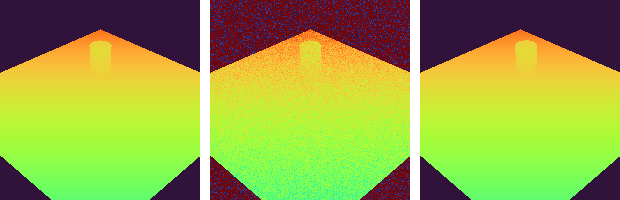

In [31]:
inf_img = render_scene(inferred_scene, renderer, cam_pose)
j.hstack_images([j.get_depth_image(gt_img[:,:,2], max=3.0), j.get_depth_image(obs[:,:,2], max=3.0),
                 j.get_depth_image(inf_img[:,:,2], max=3.0)])

In [32]:
scene

Scene(obj_idx=Array(0, dtype=int32), obj_contact_params=Array([-0.16892487, -0.16892487,  1.0188202 ], dtype=float32), obj_face=Array(3, dtype=int32))

In [33]:
inferred_scene

Scene(obj_idx=0, obj_contact_params=[Array(-0.18923825, dtype=float32), Array(-0.15138948, dtype=float32), Array(0.90485156, dtype=float32)], obj_face=2)

In [34]:
def sound_coarse_to_fine_inference(obs, mxs, mys, mthetas, n_mcs):
    assert len(mxs) == len(mys) and len(mys) == len(mthetas)
    obj_idxs, faces = range(len(MODEL_NAMES)), range(6)
    x_range, y_range, t_range = (-TABLE_WID/4, TABLE_WID/4), (-TABLE_LEN/4, TABLE_LEN/4), (0, 2*jnp.pi)
    for (mx, my, mt, n_mc) in zip(mxs, mys, mthetas, n_mcs):
        full_scores = jnp.zeros((n_mc, len(obj_idxs), len(faces), mx*my*mt))
        for i in range(n_mc):
            print(f'grid: {mx} {my} {mt} {i}')
            scores, grid = score_grid(obs, x_range, y_range, t_range, obj_idxs, faces, mx, my, mt)
            full_scores = full_scores.at[i,...].set(scores)
        scores = jax.scipy.special.logsumexp(full_scores, axis=0) - jnp.log(n_mc)
        obj_idx, face, ix, iy, it = sample_from_scores(scores, len(obj_idxs), len(faces), mx, my, mt)
        obj_idxs, faces = [obj_idxs[obj_idx]], [faces[face]]
        x_range = (grid.x_grid[ix], grid.x_grid[ix+1])
        y_range = (grid.y_grid[iy], grid.y_grid[iy+1])
        t_range = (grid.t_grid[it], grid.t_grid[it+1])
    return obj_idxs, faces, x_range, y_range, t_range

In [35]:
c2f_inf = sound_coarse_to_fine_inference(obs, mxs=(5,5), mys=(5,5), mthetas=(5,5), n_mcs=(2,2))

grid: 5 5 5 0
..............................................................................................................................
grid: 5 5 5 1
..............................................................................................................................
grid: 5 5 5 0
.
grid: 5 5 5 1
.


In [36]:
_obj_idx = c2f_inf[0][0]
_dx = (c2f_inf[2][0] + c2f_inf[2][1])/2
_dy = (c2f_inf[3][0] + c2f_inf[3][1])/2
_dt = (c2f_inf[4][0] + c2f_inf[4][1])/2
_face = c2f_inf[1][0]
c2f_scene = Scene(_obj_idx, [_dx, _dy, _dt], _face)

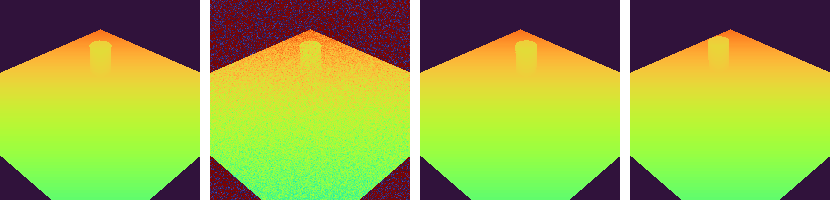

In [37]:
c2f_img = render_scene(c2f_scene, renderer, cam_pose)
j.hstack_images([j.get_depth_image(gt_img[:,:,2], max=3.0),
                 j.get_depth_image(obs[:,:,2], max=3.0),
                 j.get_depth_image(inf_img[:,:,2], max=3.0),
                 j.get_depth_image(c2f_img[:,:,2], max=3.0)])

In [38]:
c2f_scene

Scene(obj_idx=0, obj_contact_params=[Array(-0.16, dtype=float32), Array(-0.24000001, dtype=float32), Array(1.1309733, dtype=float32)], obj_face=2)

In [52]:
def sound_adaptive_inference(obs, mx, my, mtheta, n_mc, epsilon=0.1):
    ...

---

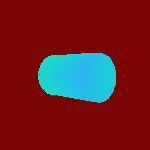

In [14]:
object_pose = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
  .001, 0.1)

# object_pose2 = j.distributions.gaussian_vmf_sample(
#     jax.random.PRNGKey(2),
#     j.t3d.transform_from_pos(
#         jnp.array([0.05, 0.0, 0.2])
#     ),
#     0.001, 0.1
# )

GT_ID = 3
observed_depth = renderer.render_multiobject(
    jnp.array([object_pose, ]),#object_pose2]),
    [GT_ID, 16]
)[...,2]
noise = jax.random.normal(jax.random.PRNGKey(10), observed_depth.shape) * 0.0
observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
observed_image = j.t3d.unproject_depth_jit(observed_depth + noise, intrinsics)
observed_image_viz = j.get_depth_image(observed_image[:,:,2],max=intrinsics.far)
observed_image_viz

In [21]:
# configure c2f
grid_widths = [0.1, 0.05, 0.03, 0.01, 0.01, 0.01]
rot_angle_widths = [jnp.pi, jnp.pi, jnp.pi, jnp.pi, jnp.pi/5, jnp.pi/5]
sphere_angle_widths = [jnp.pi, jnp.pi/2, jnp.pi/4, jnp.pi/4, jnp.pi/5, jnp.pi/5]
grid_params =  [(3,3,3,75*5,15), (3,3,3,75*3,21),(3,3,3,55,45),(3,3,3,55,45), (3,3,3,45,45), (3,3,3,45,45)]  # (num_x, num_y, num_z, num_fib_sphere, num_planar_angle)

scheds = j.c2f.make_schedules(
    grid_widths=grid_widths, 
    angle_widths=rot_angle_widths, 
    grid_params=grid_params, 
    full_pose=True, 
    sphere_angle_widths=sphere_angle_widths
)


In [22]:
len(scheds)

6

In [32]:
jax.random.truncated_normal(jax.random.PRNGKey(2), -1, 1)

Array(-0.13038644, dtype=float32)

In [20]:
POSE_MEAN = j.t3d.transform_from_pos(jnp.array([0.0, 0.0, 0.3]))
POSE_VAR = 0.001
POSE_CON = 0.1
NUM_MODELS = len(model_names)

In [ ]:
def sound_fine_inference(point_cloud_image, GT_ID, num_iterations=None):

In [5]:
def get_pose_estimate(point_cloud_image, GT_ID, init_pose=None, num_iterations=None):
    if init_pose is None:
        center = jnp.mean(point_cloud_image[point_cloud_image[:,:,2]< intrinsics.far],axis=0)
        pose_estimate = j.t3d.transform_from_pos(center)
    else:
        pose_estimate = init_pose
    best_weight = -jnp.inf
    
    if num_iterations is None:
        num_iterations = len(scheds)
    
    for iteration in range(num_iterations):
        deltas = scheds[iteration]
        for batch in jnp.array_split(deltas, deltas.shape[0] // 2000):
            pose_proposals = jnp.einsum('ij,ajk->aik', pose_estimate, batch)

            rendered_depth = renderer.render_parallel(pose_proposals, GT_ID)[...,2]
            rendered_point_cloud_images = j.t3d.unproject_depth_vmap_jit(rendered_depth, intrinsics)

            R_SWEEP = jnp.array([0.01])
            OUTLIER_PROB=0.05
            OUTLIER_VOLUME=100.0
            weights = j.threedp3_likelihood_with_r_parallel_jit(
                point_cloud_image, rendered_point_cloud_images, R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME
            )
            if weights.max() > best_weight:
                pose_estimate = pose_proposals[weights.argmax()]
                best_weight = weights.max()
        print(best_weight)
    return pose_estimate

In [6]:
ID = 9
ID = GT_ID
pose_estimate = get_pose_estimate(observed_image, ID, init_pose=j.t3d.transform_from_pos(object_pose[:3,3]))

48838.08
48839.85
48839.85
48839.85
48841.81
48841.81


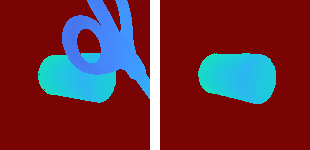

In [7]:
reconstructed_depth = renderer.render_multiobject(
    jnp.array([pose_estimate]),
    [ID]
)[...,2]
# noise = jax.random.normal(jax.random.PRNGKey(10), observed_depth.shape) * 0.001
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
rendered_image = j.t3d.unproject_depth_jit(reconstructed_depth, intrinsics)
rendered_image_viz = j.get_depth_image(rendered_image[:,:,2],max=intrinsics.far)
j.hstack_images(
    [
        observed_image_viz,
        rendered_image_viz
    ]
)

In [8]:
def likelihood(obs_xyz, rendered_xyz, r, outlier_prob, outlier_volume):
    num_latent_points = obs_xyz.shape[1] * obs_xyz.shape[0]
    probs = j.gaussian_mixture_image(obs_xyz, rendered_xyz, r)
    probs_with_outlier_model = probs * (1.0 - outlier_prob) / num_latent_points   + outlier_prob / outlier_volume
    return (jnp.log(probs_with_outlier_model)).sum() 

def make_outlier_posterior_graph(x,y):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x, y, label="Matched", color=color)
    plt.fill_between(x, y, color=color, alpha=0.5)
    plt.xlim((-0.05, 0.25))
    plt.ylim((0.0, 1.1))
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4],fontsize=15)
    plt.xlabel("Outlier Probability",fontsize=20)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im

def make_r_posterior_graph(x,y):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x, y, label="Matched", color=color)
    plt.fill_between(x, y, color=color, alpha=0.5)
    plt.xlim((-0.005, 0.11))
    plt.ylim((0.0, 1.1))
    plt.xticks([0.0, 0.025, 0.05, 0.075, 0.1],fontsize=15)
    plt.xlabel("R",fontsize=20)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im


likelihood_jit = jax.jit(
    jax.vmap(jax.vmap(likelihood, in_axes=(None, None, None, 0, None)), in_axes=(None, None, 0, None, None))
)

In [9]:
### 

OUTLIER_PROBS = jnp.linspace(0.005, 0.2, 100)
R = jnp.linspace(0.001, 0.05, 200)
OUTLIER_VOLUME = 1000.0
p = likelihood_jit(observed_image, rendered_image, R, OUTLIER_PROBS, OUTLIER_VOLUME)



ii,jj = jnp.unravel_index(p.argmax(), p.shape)
best_r, best_outlier_prob = (R[ii], OUTLIER_PROBS[jj])
print(R[ii], OUTLIER_PROBS[jj])

0.001 0.17636365


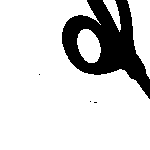

In [10]:
outliers = (
    (j.gaussian_mixture_image(observed_image, rendered_image, best_r) * (1.0 - best_outlier_prob)) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
outlier_viz = j.get_depth_image(outliers, cmap=matplotlib.colormaps['Greys'])
outlier_viz

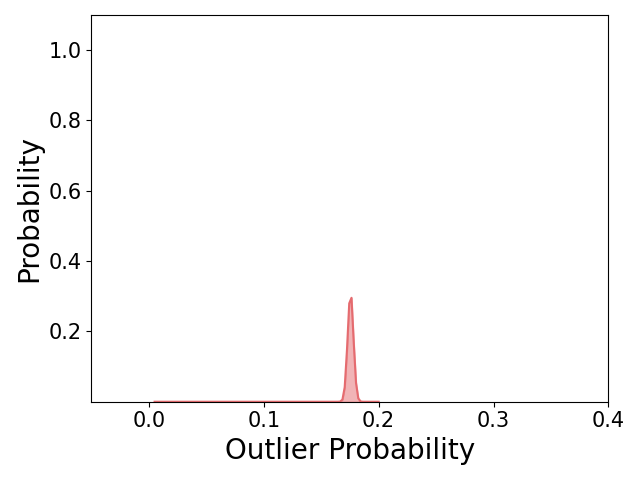

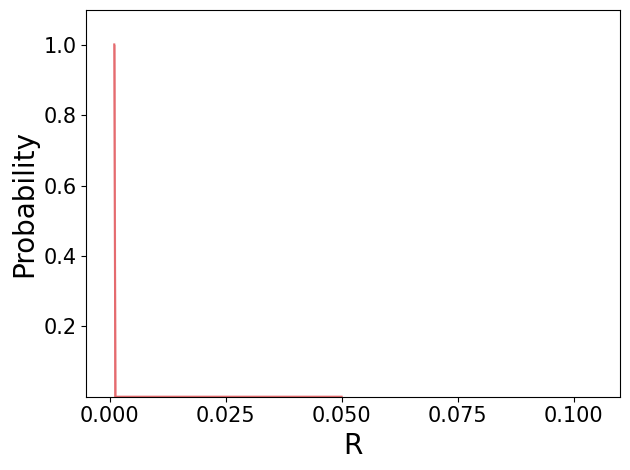

In [11]:
outlier_prob_viz = make_outlier_posterior_graph(OUTLIER_PROBS, j.utils.normalize_log_scores(p).sum(0))
r_viz = make_r_posterior_graph(R, j.utils.normalize_log_scores(p).sum(1))
outlier_prob_viz

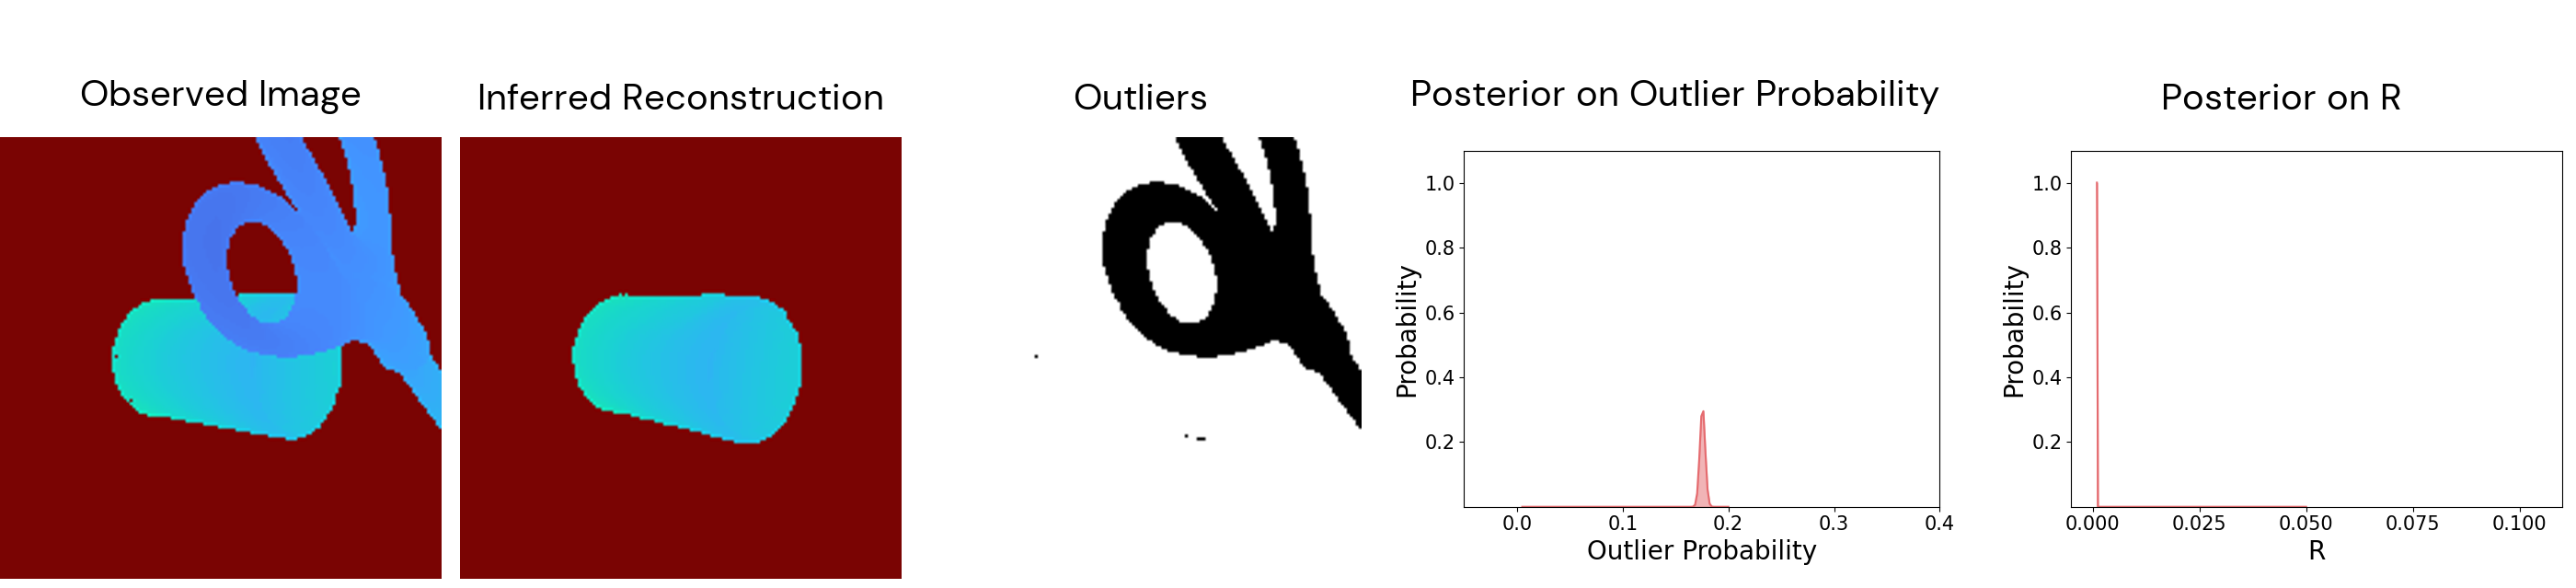

In [12]:
height_factor = outlier_prob_viz.height / observed_image_viz.height
panel = j.multi_panel(
    [
        j.scale_image(observed_image_viz,height_factor),
        j.scale_image(rendered_image_viz,height_factor),
        j.scale_image(outlier_viz,height_factor),
        outlier_prob_viz, r_viz],
    labels=["Observed Image", "Inferred Reconstruction", "Outliers", "Posterior on Outlier Probability", "Posterior on R"],
    label_fontsize=40,
    middle_width = 20
)
panel

/tmp/ipykernel_3804/3628203880.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

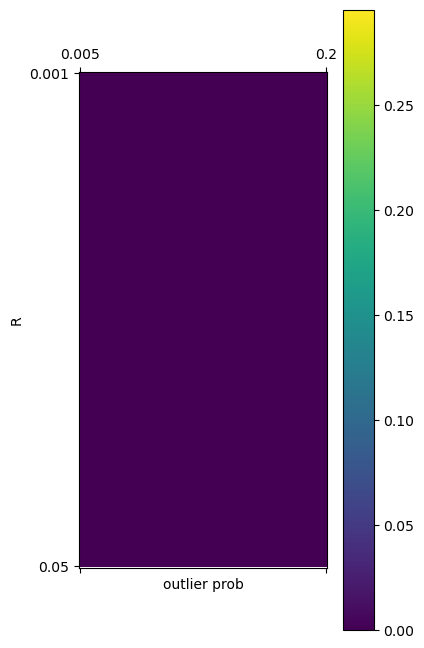

In [13]:
plt.clf()
plt.matshow(j.utils.normalize_log_scores(p))
plt.xlabel("outlier prob")
plt.ylabel("R")
plt.yticks([0,len(R)-1],[str(np.round(R[0].item(),6)), str(np.round(R[-1].item(),6)) ])
plt.xticks([0,len(OUTLIER_PROBS)-1],[str(np.round(OUTLIER_PROBS[0].item(),6)),str(np.round(OUTLIER_PROBS[-1].item(),6))])
# ([str(OUTLIER_PROBS[0].item())] + ['' for _ in range(len(OUTLIER_PROBS)-2)] + [str(OUTLIER_PROBS[-1].item())])
plt.colorbar()
plt.tight_layout()
plt.savefig("1.png")
